# Lymphocyte Detection

The goal is to detect every lymphocye in an image and annotate the original image with the location of each lymphocyte.

## 1. Install required packages
Please uncomment the following cells to install the required packages.

Python version: 3.6.9

In [1]:
#!python3 --version

Python 3.6.9


In [2]:
#!pip install matplotlib==3.3.2

In [3]:
#!pip install opencv-python

In [4]:
#!pip install scikit-image==0.17.2

In [5]:
#!pip install sklearn

In [6]:
#!pip install mahotas

## 2. Build a Binary Classifier (Lymphocyte vs. Non-Lymphocyte)

In here, we build a classifier to categorize a lymphocyte candidate as Lymphocyte vs non-Lymphocyte.

### 2.1. Prepare dataset

We first annotate the orginal dataset with postive and negatives patches. A positive patch is a Lymphocyte and a negative patch is a Non-Lymphocyte. Then we extract these patches and store them in *pos_patches* and *neg_patches*.

In [7]:
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

image_path = './annotation/img/'
annotation_path = './annotation/annotations/'
org_img_path = "./data/"


annotations = os.listdir(annotation_path)
images = os.listdir(image_path)
count = 0

pos_patches = []
neg_patches = []
for a in annotations:
    a1 = a.split('.')
    image = cv2.imread(image_path + a1[0] + '.jpg')
    dh, dw, _ = image.shape

    fl = open(annotation_path + a, 'r')
    data = fl.readlines()
    fl.close()
    for dt in data:
        # Split string to float
        c, x, y, w, h = map(float, dt.split(' '))
        l = int((x - w / 2) * dw)
        r = int((x + w / 2) * dw)
        t = int((y - h / 2) * dh)
        b = int((y + h / 2) * dh)

        l = 0 if l < 0 else l
        r = dw - 1 if r > dw - 1 else r
        t = 0 if t < 0 else t
        b = dh - 1 if b > dh - 1 else b
        
        # scal back the buinding box to the original image
        scale = 4.16
        t = int(t/scale)
        b = int(b/scale)
        l = int(l/scale)
        r = int(r/scale)

        image = cv2.imread(org_img_path + a1[0] + '.tif')

        if c == 1:
            neg_patches.append(image[t:b, l:r, :])
        else:
            pos_patches.append(image[t:b, l:r, :])

print("Number of positive samples: ", len(pos_patches))
print("Number of negative samples: ", len(neg_patches))

Number of positive samples:  446
Number of negative samples:  214


### 2.2. Feature Extraction

Now that we have the dataset ready, we need to extract features for each sample, *i.e.,* Lymphocyte/Non-Lymphocyte. I use **haralick texture features** for the classifier. I extract 13 texture features, e.g., constrast, sum entropy, energy, etc. Please refer to the report for the complete set of features extracted. I use *mahotas* package to extract these features.

#### A helper function for feature extraction

In [8]:
import mahotas as mt
def extract_texture_features(image):
        # calculate haralick texture features for 4 types of adjacency
        textures = mt.features.haralick(image)

        # take the mean of it and return it
        ht_mean = textures.mean(axis=0)
        return ht_mean

#### Exctract features for positive samples

In [9]:
# extract features from pos_patches
target = []
dataset = []
count = 1
data_size = min(len(pos_patches), len(neg_patches))
for p in pos_patches[:data_size]:
    #print(p.shape)
    gray = cv2.cvtColor(p, cv2.COLOR_BGR2GRAY)
    #cv2.imwrite("./out2/" + str(count) + ".jpg", gray)
    count += 1
    dataset.append(extract_texture_features(gray))
    target.append(1)
print("EXtracted features for %s positive samples"% data_size)

EXtracted features for 214 positive samples


#### Exctract features for negative samples

In [10]:
# extract features from neg_patches
for p in neg_patches[:data_size]:
    gray = cv2.cvtColor(p, cv2.COLOR_BGR2GRAY)
    dataset.append(extract_texture_features(gray))
    target.append(0)
print("EXtracted features for %s negative samples"% data_size)

EXtracted features for 214 negative samples


### 3.3. Train an SVM Classifier

We then split the dataset into train and test. We use 20% of the dataset for testing.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_train, X_test, y_train, y_test = train_test_split(
       dataset, target, test_size=0.1, random_state=42)

Now, we train an SVM classifier. We also normalize the features.

In [12]:
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

pipeline = make_pipeline(MinMaxScaler(), SVC(C=100, kernel='linear', probability=1, gamma='scale'))

print("Fitting the classifier..")
clf_svm = pipeline.fit(X_train, y_train)

Fitting the classifier..


### 3.4. Test the model

Here we test the model we trained in the previous section and compute different metrics to evaluate the performance of the model.

In [13]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

pred = clf_svm.predict(X_test)

print("Precision: {:.2f}".format(precision_score(y_test,pred)))
print("Recall: {:.2f}".format(recall_score(y_test,pred)))
print("Accuracy: {:.2f}".format(accuracy_score(y_test,pred)))
print("F-1 score: {:.2f}".format(f1_score(y_test,pred)))

Precision: 0.81
Recall: 0.96
Accuracy: 0.86
F-1 score: 0.88


In [14]:
from sklearn.metrics import confusion_matrix

print("Confusion matrix:")
confusion_matrix(y_test, pred)

Confusion matrix:


array([[15,  5],
       [ 1, 22]])

## 3. Inference

Now we develop a pipeline to detect lymphocyte using the model that we built in the previous section. Please refer to the report for the details

In [15]:
# The image that we want to detect its lymphocytes
target_image = '80.tif'
target_image_path = './data/' + target_image

### 3.1. Meanshift-based clustering

number of estimated clusters : 167


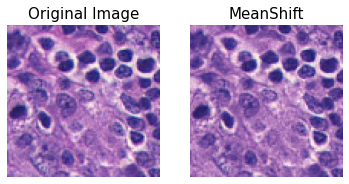

In [16]:
import numpy as np    
import cv2    
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
import skimage
from skimage.color import lab2rgb, lch2lab, label2rgb, rgb2hsv

#Loading original image
org_image = cv2.imread(target_image_path)
img_height, img_width = org_image.shape[0], org_image.shape[1]

image = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)

# Shape of original image    
originShape = image.shape

# Converting image into array of dimension [nb of pixels in originImage, 3]
# based on r g b intensities    
flatImg=np.reshape(image, [-1, 3])

# Estimate bandwidth for meanshift algorithm    
bandwidth = estimate_bandwidth(flatImg, quantile=0.007, n_samples=1000)    
ms = MeanShift(bandwidth = bandwidth, bin_seeding=True)

# Performing meanshift on flatImg    
ms.fit(flatImg)

# (r,g,b) vectors corresponding to the different clusters after meanshift    
labels=ms.labels_

# Remaining colors after meanshift
cluster_centers = ms.cluster_centers_    

# Finding and diplaying the number of clusters    
labels_unique = np.unique(labels)    
n_clusters_ = len(labels_unique)    
print("number of estimated clusters : %d" % n_clusters_)    

# Displaying segmented image    
segmentedImg = np.reshape(labels, originShape[:2])    
mean_shift = label2rgb(segmentedImg, image, kind='avg')
plt.figure()
plt.subplot(121), plt.imshow(image), plt.axis('off'), plt.title('Original Image', size=15)
plt.subplot(122), plt.imshow(mean_shift), plt.axis('off'), plt.title('MeanShift', size=15)
plt.show()

### 3.2. HSV-based thresholding

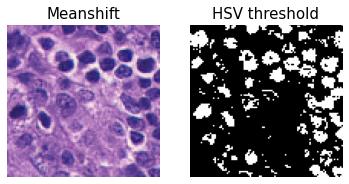

In [17]:
import skimage

sample_h = rgb2hsv(mean_shift)
hsv = np.zeros((img_height,img_width), dtype = 'uint8')
for i in range(img_height):
    for j in range(img_width):
        if sample_h[i,j,0] >= 0.6467 and sample_h[i,j,0] <= 0.7292:
            hsv[i,j]=1

plt.figure()
plt.subplot(121),plt.imshow(mean_shift), plt.axis('off'), plt.title('Meanshift', size=15)
plt.subplot(122),plt.imshow(hsv, cmap='gray'), plt.axis('off'), plt.title('HSV threshold', size=15)
plt.show()

### 3.3. Connected Component Analysis

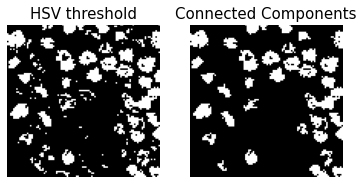

In [18]:
output = cv2.connectedComponentsWithStats(hsv)
(numLabels, labels, stats, centroids) = output
mask = np.zeros(hsv.shape, dtype="uint8")

# loop over the number of unique connected component labels, skipping
# over the first label (as label zero is the background)
for i in range(1, numLabels):
    # extract the connected component statistics for the current label
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    
    # ensure the width, height, and area are all neither too small
    # nor too big
    keepWidth = w > 5 and w < 30
    keepHeight = h > 5 and h < 30
    keepArea = area > 10
    # ensure the connected component we are examining passes all
    # three tests
    if all((keepWidth, keepHeight, keepArea)):
        # construct a mask for the current connected component and
        # then take the bitwise OR with the mask       
        componentMask = (labels == i).astype("uint8") * 1
        mask = cv2.bitwise_or(mask, componentMask)

plt.figure()
plt.subplot(121),plt.imshow(hsv, cmap='gray'), plt.axis('off'), plt.title('HSV threshold', size=15)
plt.subplot(122),plt.imshow(mask, cmap='gray'), plt.axis('off'), plt.title('Connected Components', size=15)
plt.show()

### 3.6. Predict

I first ectract all lymphocyte candidates  and then use the classifer to categorize them as Lymphocyte vs. non-lymphocyte. In other words, I extract candidates (based on connected component analysis results from previous section) from the original image and then convert it to gray scale. Then I extract texture features for each candidate and feed the features to the trained model to callify the lymphocyte. Once I find a lymphocyte, I put a green dot on the center of it.

#### A helper function to get all lymphocyte candidates

In [19]:
# gray_image: (equalized x hsv)
# stats, numLabels:: connected component results
def get_all_candidates(gray_image, stats, numLabels):
    candidates = {}
    cnt = 1
    for i in range(1, numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]

        # ensure the width, height, and area are all neither too small
        # nor too big
        keepWidth = w > 5 and w < 30
        keepHeight = h > 5 and h < 30
        keepArea = area > 10
        # ensure the connected component we are examining passes all
        # three tests
        if all((keepWidth, keepHeight, keepArea)):
            patch = org_image[y:y+h,x:x+w]
            center = (x+(w//2),y+(h//2))
            candidates[center] = patch    
    return candidates    

Get the candidates.

In [20]:
candidates = get_all_candidates(mask, stats, numLabels)

#### A helper function to annotate the image with lymphocyte locations

In [21]:
def annotate_image(image, candidates, model):

    for candidate in candidates:
        patch = candidates[candidate]
        # convert to gray scale
        patch_gray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
        # extract features
        features = extract_texture_features(patch_gray)
        # centre of the candidate lymphocyte
        center_x, center_y = candidate
        # get the prediction
        pred = clf_svm.predict([features])
        if pred == 1:
            image[center_y, center_x] = [0,255,0]
        #else:
        #    image[center_y, center_x] = [0,0,255]

Now, lets annotate the image with the location of lymphocytes.

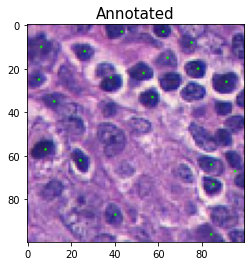

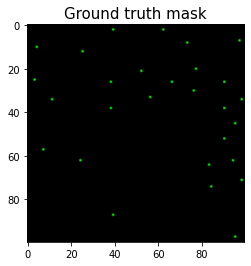

In [22]:
# display the annotated image along with its ground truth
org_image_rgb = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)
annotate_image(org_image_rgb, candidates, clf_svm)
plt.imshow(org_image_rgb)
plt.title('Annotated', size=15)
plt.show()
gt = cv2.imread('./data/manual_seg/' + target_image)
plt.imshow(gt, cmap='gray')
plt.title('Ground truth mask', size=15)
plt.show()
